# Statistics for AI & Data Science - QMID: 200851709

## US Department of Transport(USDT) - Bridge Condition Analysis

### Contents
1. Introducting the Data
    1. The Data 
    2. The Task
2. Data Preprocessing
    1. Initial Look At The Data
    2. Discretizing Ordinal Target Data
    3. Feature Engineering - Combining Target Variables
		1. Rationale 
		2. Observations 
    4. Catergory Consolidation
		1. Rationale 
3. Exploratory Analysis & Preliminary Conclusions 
	1. Numerical Variables 
		1. Plots
		2. Observations 
		3. Modifications 
																													
    2. Target vs Predictor Relationships  
        1. Plotting
		2. Observations **************** Need to say something here 
		
    3. Predictor vs Predictor Relationships 
		1. Numerical vs Numerical
		2. Catergorical vs Catergorical
		3. Catergorical vs Numerical
		
    4. Preliminary Conclusions
	
4. Regression Analysis
    1. Make the model 
	2. Evaluating The Coefficients
    3. R2 and RMSE 
    4. Residuals 
		1. Plots
		2. Analysis
    4. Predictor Influence
    5. Final Conclusion 


## Part 1 | Introduction
### Part 1.1 | The Data
The following dataset represent bridge data submitted annually to FHWA by the States, Federal agencies, and Tribal governments in accordance with the National Bridge Inspection Standards and the Recording and Coding Guide for the Structure Inventory and Appraisal of the Nations Bridges. 
| Column           | Dtype   | Description                                                         |
|------------------|---------|---------------------------------------------------------------------|
| Structure_id     | catergory  | Unique identifier for each bridge structure                         |
| District         | catergory  | Administrative district                                             |
| Detour_Km        | int64   | Detour length in kilometers                                         |
| Toll             | catergory  | Indicates if the bridge is a toll bridge                            |
| Maintainer       | catergory  | Entity responsible for maintaining the bridge                       |
| Urban            | catergory  | Indicates if the bridge is in an urban area                         |
| Status           | catergory  | Operational status of the bridge                                     |
| **Year**             | int64   | Year of construction or last major reconstruction                    |
| Lanes_on         | int64   | Number of lanes on the bridge                                        |
| Lanes_under      | int64   | Number of lanes under the bridge                                     |
| **AverageDaily**     | int64   | Average daily traffic on the bridge                                  |
| Historic         | catergory  | Indicates if the bridge is historic                                  |
| Service_under    | catergory  | Type of service under the bridge                                     |
| **Material**         | catergory  | Material type of the bridge                                          |
| **Design**         | catergory  | Design type of the bridge                                            |
| Spans            | int64   | Number of spans                                                     |
| Length           | float64 | Length of the bridge in meters                                       |
| Width            | float64 | Width of the bridge in meters                                        |
| **Deck_rating**      | catergory  | Condition rating of the bridge deck                                  |
| **Superstr_rating**  | catergory  | Condition rating of the bridge superstructure                        |
| **Substr_rating**    | catergory  | Condition rating of the bridge substructure                          |
| Rated_load       | float64 | Rated load capacity of the bridge                                    |
| **Trucks_percent**   | float64 | Percentage of truck traffic on the bridge                            |
| Scour_rating     | catergory  | Condition rating of the bridge in terms of scour potential           |
| Future_traffic   | int64   | Projected future traffic on the bridge                               |

### Part 1.2 | The Task 

The USDT has asked for an investigation into the current condition of bridges in Texas. Specifically how Five predictor variables can be used to predict the condition.

**The Predictor Variables Are:**
1. Age (derived from variable Year)
2. AverageDaily
3. Trucks_percent
4. Material 
5. Design 

**The Target Variables Are:**

1. Deck_rating
2. Superstr_rating
3. Substr_rating variables

**This study aims to find:**:
1. How well the proposed variables can predict the bridge condition.
2. Which of the proposed variables has more influence on the current condition.

## Part 2: Data Preprocessing

### Part 2.1 | Initial Look At The Data

After loading the data some cleansing is performed. The following steps are taken: 
* The desired variables are isolated from the rest. These are: 
    * Predictors: **'AverageDaily', 'Year', 'Trucks_percent', 'Material', 'Design'**
    * Targets: **'Deck_rating', 'Superstr_rating', 'Substr_rating'**. 

* The bridges 'Age' is derived from the 'Year'. The year is then dropped. 
* 7 entries with empty values were removed 

> ***Assumptions Made:***
>* We have assumed that the 7 values dropped are not important to the analysis


In [669]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from datetime import datetime
import matplotlib.gridspec as gridspec

# read the bridges_data.csv file into a dataframe
df = pd.read_csv('tx19_bridges_sample.csv')

# independant variables
independant_variables = ['AverageDaily', 'Year', 'Trucks_percent', 'Material', 'Design', ]
# dependant_variables
dependant_variables = ['Deck_rating', 'Superstr_rating', 'Substr_rating']

# create a subset of the dataframe
df_subset = df.loc[:, dependant_variables + independant_variables]

# assign a age column and drop the year
df_subset = df_subset.assign(Age = datetime.now().year - df_subset['Year'])
df_subset = df_subset.drop('Year', axis=1)

# check the data for missing values and count them. Remove them 
missing_count = df_subset.isna().any(axis=1).sum()
df_subset.dropna(inplace=True)

df_subset.head(10)


,Deck_rating,Superstr_rating,Substr_rating,AverageDaily,Trucks_percent,Material,Design,Age
0,Good,Very Good,Very Good,1,0.0,Concrete,Slab,19
1,Good,Good,Very Good,1,0.0,Concrete,Slab,19
2,Very Good,Very Good,Very Good,100,0.0,Concrete,Beam,12
3,Good,Good,Poor,80,0.0,Timber,Beam,74
4,Good,Very Good,Very Good,150,4.0,Concrete,Beam,20
5,Very Good,Very Good,Very Good,150,4.0,Concrete,Beam,19
6,Good,Very Good,Very Good,20,0.0,Timber,Beam,7
7,Fair,Fair,Poor,10,0.0,Timber,Beam,74
8,Fair,Good,Satisfactory,40,0.0,Timber,Beam,74
9,Good,Satisfactory,Fair,40,0.0,Timber,Beam,74


### Part 2.2 | Discretizing Ordinal Target Data
* ***'Deck_rating, Superstr_rating & Substr_rating'***  are all catergorical variables but have an ordinal nature. 
* There values are all coded according to the following table obtained from the US Department of Transport 
* Therefor the data is transformed into numerical values from 1-9
* ***This quantifiable format makes statistical analysis possible*** 

| Code | Description                                                                                                                   |
 |------|-------------------------------------------------------------------------------------------------------------------------------|
 | N    | NOT APPLICABLE                                                                                                                |
 | 9    | EXCELLENT CONDITION                                                                                                           |
 | 8    | VERY GOOD CONDITION                                                                                      |
 | 7    | GOOD CONDITION                                                                                 |
 | 6    | SATISFACTORY CONDITION                                                   |
 | 5    | FAIR CONDITION   |
 | 4    | POOR CONDITION                                                   |
 | 3    | SERIOUS CONDITION -|
 | 2    | CRITICAL CONDITION |
 | 1    | FAILING CONDITION -|
 | 0    | FAILED CONDITION                                                                  |


> ***Assumptions Made***: 
> * We are assuming the difference bewteen the condition ratings is consistent and linear. 

In [670]:
condition_mapping = {
    'Excellent': 9,
    'Very Good': 8,
    'Good': 7,
    'Satisfactory': 6,
    'Fair': 5,
    'Poor': 4,
    'Serious': 3,
    'Critical': 2,
    'Failing': 1,
    'Failed': 0
}

def change_encoding(string):
    return condition_mapping[string]

# handle NaN rows by removing rows. Convert the condition variables. 
for var in dependant_variables:
    # df_subset = df_subset.dropna(subset=[var], axis=0)
    df_subset[var] = df_subset[var].apply(change_encoding)
    
df_subset
    

,Deck_rating,Superstr_rating,Substr_rating,AverageDaily,Trucks_percent,Material,Design,Age
0,7,8,8,1,0.0,Concrete,Slab,19
1,7,7,8,1,0.0,Concrete,Slab,19
2,8,8,8,100,0.0,Concrete,Beam,12
3,7,7,4,80,0.0,Timber,Beam,74
4,7,8,8,150,4.0,Concrete,Beam,20
...,...,...,...,...,...,...,...,...
34288,7,7,7,300,40.0,Concrete,Beam,30
34289,7,7,7,300,40.0,Concrete,Beam,24
34290,7,7,7,1200,25.0,Concrete,Beam,28
34291,7,7,6,300,15.0,Concrete,Beam,33


### Part 2.3 | Feature Engineering - Combining Target Variables

#### Part 2.3a | Rationale

As the target variables, **Deck Rating, Superstr_rating & Substr_rating**, have the same units, they can be combined to simplify the analysis. Here they are summed together and their total is used as the new single 'Condition' Variable. Simplifying the analysis like this may have the added benefits of: 
* Enhancing the overall signal of common trends
* Decrased redundancy
* Decreases potential multicollinearity issues 
> ***Assumptions Made***
>* By combining the __Deck Rating, Superstr_rating & Substr_rating__ variables, we assume they are additive and their combined effect is interpretable. This implies: 
>    * They are on a similar scale. 
>    * Their relationship is linear and does not have any interaction 

***Distribution Plots***

The distributions of the orignal and new data are plotted for inspection 

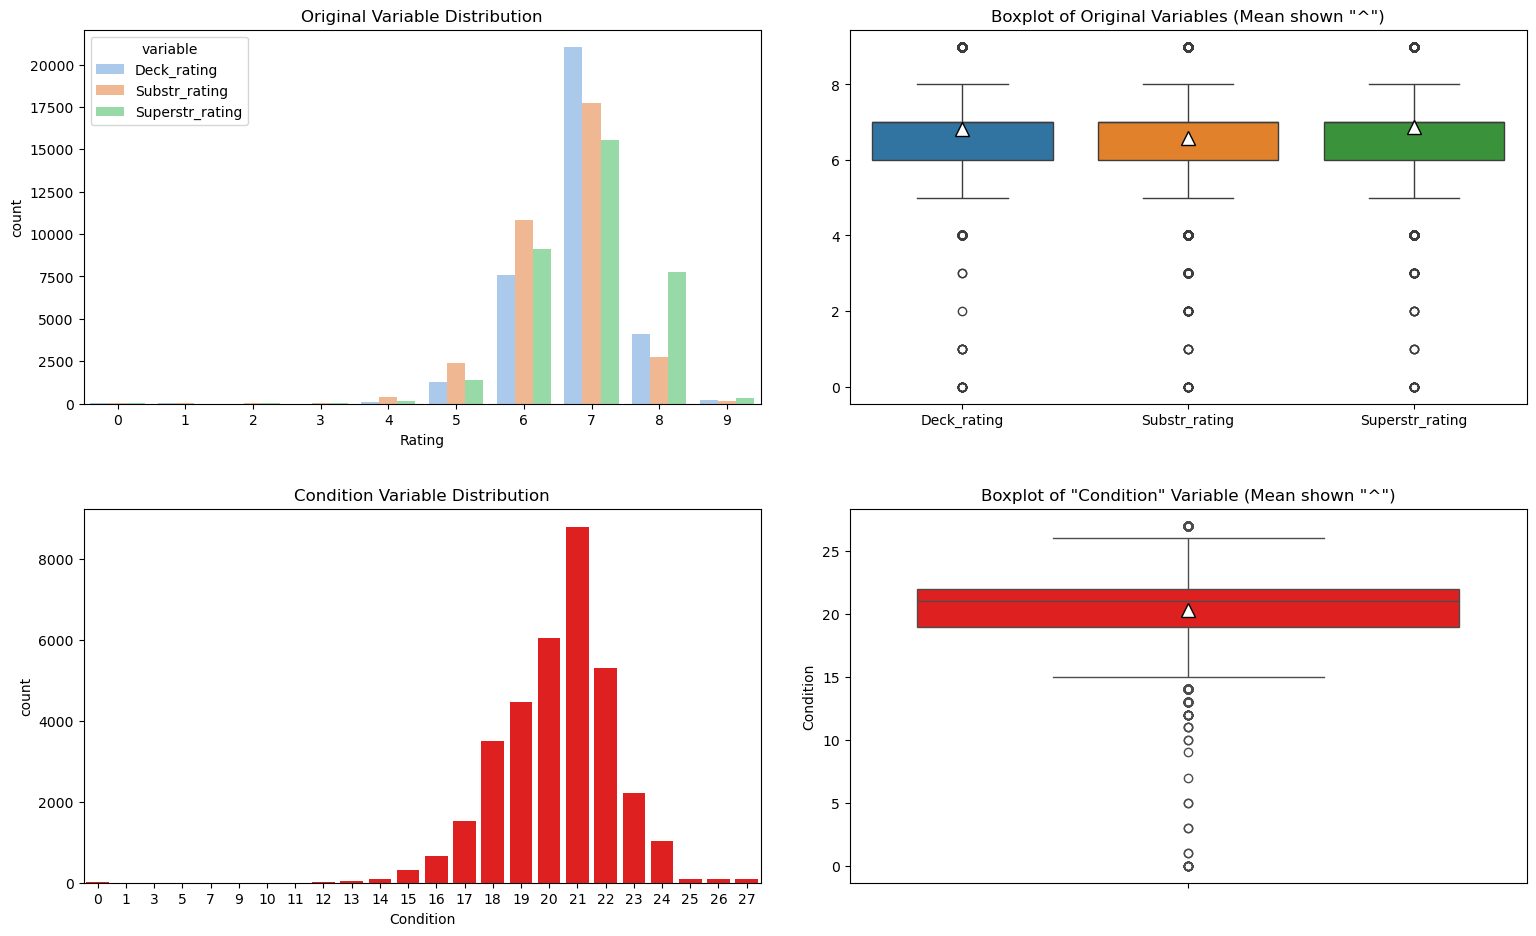

In [671]:
# create a 'condition' variable   
df_subset = df_subset.assign(Condition = df_subset[dependant_variables].sum(axis=1))

fig, axes = plt.subplots(2, 2, figsize=(16,  10))
axes = axes.flatten()

# plot the original variable distribution
filtered_df_melt = pd.melt(df_subset.loc[:, ['Deck_rating', 'Substr_rating', 'Superstr_rating']],  var_name='variable', value_name='Value')
sns.countplot(data=filtered_df_melt, x='Value', hue='variable', palette='pastel',ax=axes[0])
axes[0].set_title('Original Variable Distribution')
axes[0].set_xlabel('Rating')

# plot the boxplot of the 3 orignal variables
sns.boxplot(data=df_subset.loc[:, ['Deck_rating', 'Substr_rating', 'Superstr_rating']], ax=axes[1], showmeans=True, meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":10})
axes[1].set_title('Boxplot of Original Variables (Mean shown "^")')

#  the condition variable distribution
sns.countplot(data=df_subset, x='Condition', ax=axes[2], color = 'red')
axes[2].set_title('Condition Variable Distribution')
axes[2].set_xlabel('Condition')

# plot the boxplot of the condition variable
sns.boxplot(data=df_subset, y='Condition',  ax=axes[3], color = 'red', showmeans=True, meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":10})
axes[3].set_title('Boxplot of "Condition" Variable (Mean shown "^")')
plt.tight_layout(pad=3.0)

### Part 2.3b | Observations 

* The original variables, **Deck Rating, Superstr_rating & Substr_rating**, have very similar distributions. With the mean rating value for all about 7. 
* Once combined, the 'Condition' variable expectedly has a very similar distibution. With an expected mean of roughly 21, the orignal means summed. 
* **The similarity of the 2 distributions indicates the new variable retains the characteristic of the individual variables.**



## Part 2.4 | Catergory Consolidation

***Rationale***

Both **Material & Design** variables have several catergories that have relatively low frequencies compared to the very dominant 'Concrete' caterogory. They are therefore reduced by combining them into a single 'Other' catergory. Simplifying the analysis like this maybe have the added benefits of: 
* Reducing the dominance of concrete 
* Reducing noise from the infrequent categories
* Simplifying Analysis 


***Changes Made***
* **Material** variable will be made into ***Steel***, ***Concrete*** and ***'Other'*** (made up of timber, masonry and other)
 * **Design** variable will be made into ***Beam, Slab & 'Other'*** (Made up of Truss, Arch, Suspension, Frame, Moveable)

> ***Assumptions Made***
> * We assume, when aggregated into an ‘other’ category, the change has an insignificant impact on the variance and central tendency of the dataset

***Distribution Plots***

The distributions before and after the modification are plotted. 

No **Observation Section** is made. 


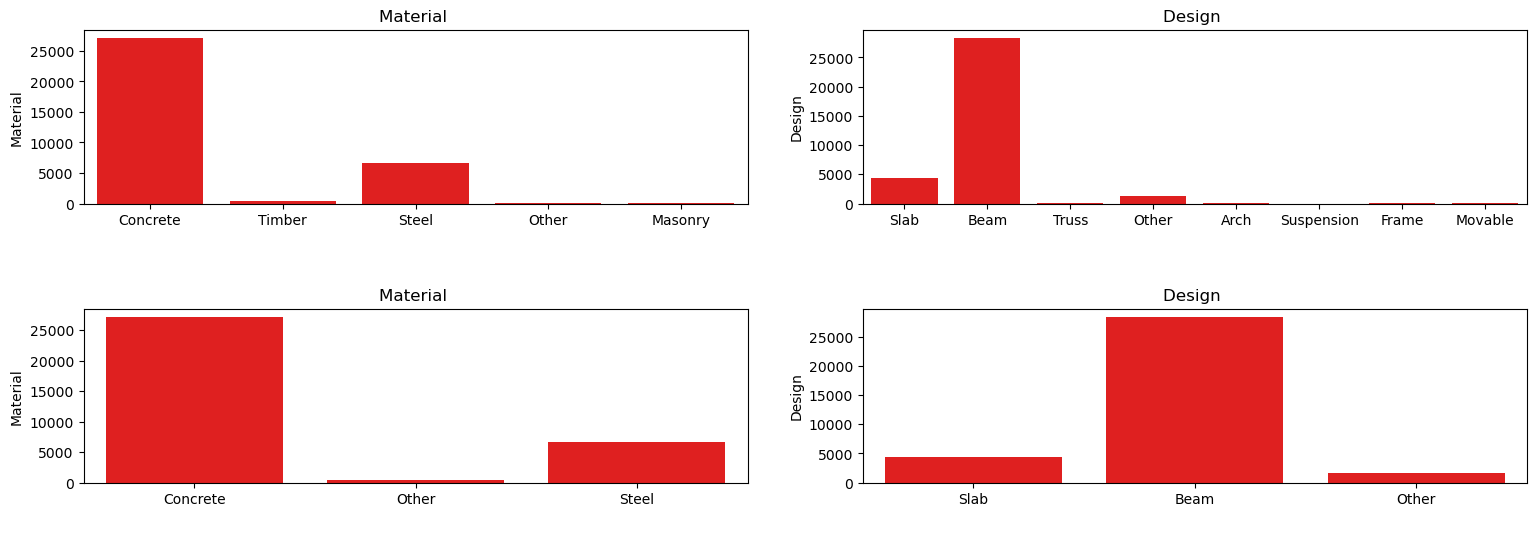

In [672]:
# declare all variable types
all_columns = list(df_subset.columns)
categorical_columns = list(df_subset.select_dtypes(include=['object']).columns)
numerical_columns = list(df_subset.select_dtypes(include=['int64', 'float64']).columns)

#  declare subplot variables
num_columns = 2
num_rows = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16,  6))
axes = axes.flatten()

plot_tracker = 0
# loop for the catergorical box plots
for col in categorical_columns:
    sns.countplot(x=df_subset[col], ax=axes[plot_tracker], color='red')
    axes[plot_tracker].set_title(f'{col} ')
    axes[plot_tracker].set_xlabel(' ')
    axes[plot_tracker].set_ylabel(col)
    plot_tracker += 1
    
# reassign materials that are not concrete or steel
df_subset['Material'] = df_subset['Material'].apply( lambda material : 'Other' if material not in  [ 'Steel', 'Concrete'] else material)

# reassign designs that are not slab or truss to other
df_subset['Design'] = df_subset['Design'].apply( lambda design : 'Other' if design not in  [ 'Slab', 'Beam'] else design)

# loop for the catergorical box plots again after the mods 
for col in categorical_columns:
    sns.countplot(x=df_subset[col], ax=axes[plot_tracker], color='red')
    axes[plot_tracker].set_title(f'{col} ')
    axes[plot_tracker].set_xlabel(' ')
    axes[plot_tracker].set_ylabel(col)
    plot_tracker += 1

plt.tight_layout(pad=3.0)

# remove the condition variables superstr_rating and substr_rating and deck_rating
df_subset = df_subset.drop(['Superstr_rating', 'Substr_rating', 'Deck_rating'], axis=1)

## Part 3 | Exploratory Analysis & Preliminary Conclusions 
Here we explore the distributions of and relationships between ***Age, Average Daily Traffic, Trucks Percent, Material, Design***, and the bridge's current ***condition***. This includes visualizing data patterns and correlations to set up our regression analysis. This step is crucial for predicting bridge conditions and pinpointing key influencing factors. At the end of the section a preliminary conclusion is made as to the questions asked by the USDT. 

### Part 3.1 | Numerical Variables
For outlier analysis, we will look at the distribution of the numerical variables **Age, Average Daily Traffic, Trucks Percent**.
#### Part 3.1a | Plots
The distributions of all the variables are plotted for inspection. Oweing to their distribution the **Trucks Percent** and **Average Daily** variables are plotted with log scale for their y-axis. 

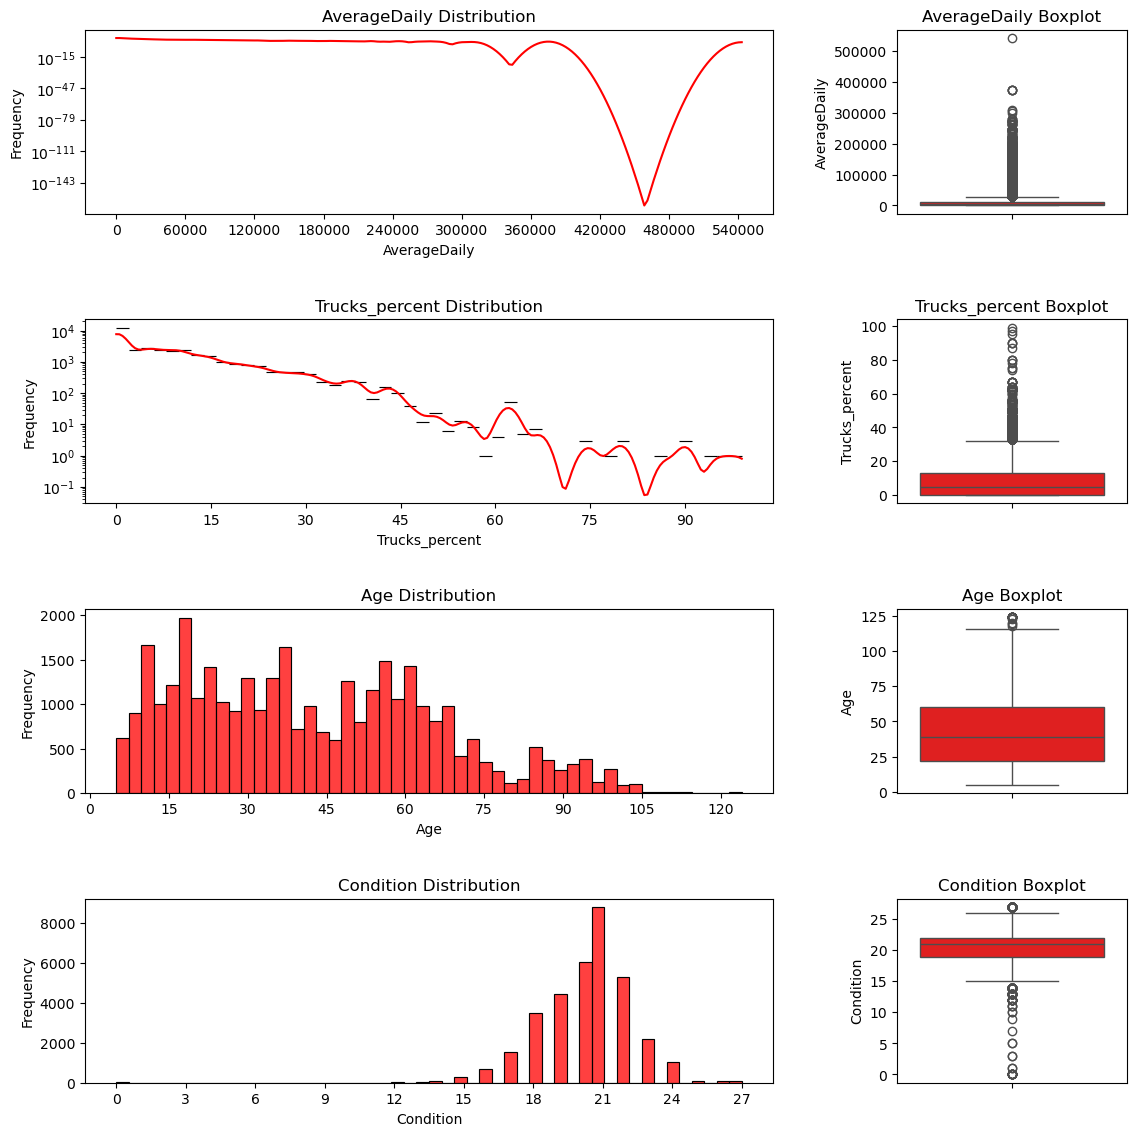

In [673]:
# to increase the amount of x axis locators 
from matplotlib.ticker import MaxNLocator

# reassign variables lists 
all_columns = list(df_subset.columns)
categorical_columns = list(df_subset.select_dtypes(include=['object']).columns)
numerical_columns = list(df_subset.select_dtypes(include=['int64', 'float64']).columns)

# declare subplot variables
num_columns = 2
num_rows = int(len(numerical_columns) )

fig = plt.figure(figsize=(12, num_rows * 3))
gs = gridspec.GridSpec(num_rows, num_columns, width_ratios=[3, 1]) # Adjust width_ratios to change size
axes = [fig.add_subplot(gs[i // num_columns, i % num_columns]) for i in range(num_rows * num_columns)]
plot_tracker = 0

# loop for the numerical scatter plots
for col in numerical_columns:
    # column 1
    if col == 'Trucks_percent' or col == 'AverageDaily': sns.histplot(df_subset[col], kde=True, log_scale=(False,True), ax=axes[plot_tracker], color='red', bins=50)
    else: sns.histplot(df_subset[col], kde=False, ax=axes[plot_tracker], color='red', bins=50)
    axes[plot_tracker].set_title(f'{col} Distribution')
    # axes[plot_tracker].set_xlabel(col)
    axes[plot_tracker].set_ylabel('Frequency')
    axes[plot_tracker].xaxis.set_major_locator(MaxNLocator(prune='both', nbins=10))
    plot_tracker += 1
    
    # columns 2 
    sns.boxplot( y=df_subset[col], ax=axes[plot_tracker], color='red')
    axes[plot_tracker].set_title(f'{col} Boxplot')
    axes[plot_tracker].set_xlabel(' ')
    # axes[plot_tracker].set_ylabel(col)
    plot_tracker += 1
    
plt.tight_layout(pad=3.0)
plt.show()

In [674]:
print('The amount of bridges with more than 60% trucks is ', df.loc[df['Trucks_percent'] > 60].shape[0])
print('The amount of bridges with an Average daily vehicle count over 30000 is ', df.loc[df['AverageDaily'] > 40000].shape[0])

The amount of bridges with more than 60% trucks is  79
The amount of bridges with an Average daily vehicle count over 30000 is  2426


### Part 3.1b | Observations

 Looking at the plots above, some observations are:
 * **Condition**: 
   * The majority of bridges are above the (13) rating. 
   * The data looks like it follows the normal distribution relatively well. However there are some outliers at the lower values. 
        * This is because most of the bridges are in a fairly good condition. 
   * The majority of the outliers are lower than the IQR and will skew the data negatively
 * **AverageDaily**:
   * The variables has a very high frequency at the lower end of the range. However only **2 bridges has a values of 0**
   * This will have a masking effect, overshadowing the variablity in the other data points. 
   * As a result the IQR of the boxplots sits against the x- axis 
    * These values do not look like mistakes. There is no noticeable pattern to them. They are of a variety of values for **age, design, material**. They simply appear to have very low traffic such that the **AverageDaily** value is rounded to the nearest integer (0)
* ***Trucks_daily***:
    * The variables has a very high frequency at the lower end of the range. 10783 have zero trucks.
    * This will likely cause model bias, making any regression too sensitive to zero truck bridges and less accurate for those with more trucks
    * This will have a masking effect, overshadowing the variablity in the other data points.
    * As a result the IQR of the boxplots sits against the x- axis 
 * **Age**: 
   * Age shows  only a few outliers around 115 years

### Part 3.1c | Modifications 
The following modifications are made to the data ***Please note that these removals are easily reversable. As the data was predicted to unduly affect the results***: 
 * **Age**: 
   * Historic bridges are removed from the data. This lowers the amount of outliers at the higher end of the distribution slightly. As shown in the lower kde in the comparative plots. 
* ***Trucks_daily***:
    * As there are only 79 bridges with more than 60% of traffic as trucks, they are removed from the data. This reduces the amount of outliers at the higher end of the distribution slightly, aas well as smooths out the noisey infrequent data at the higher part of the range. As shown in the lower kde in the comparative plots.
* ***AverageDaily***:
    * As there are 2426 bridges with over 40000 daily vehicles. While not insignificant, the bridges are rather isolated outliers, with no other data near them. As shown by the sudden spike in frequency over 40000. They are therefore removed and the resuling distribution is much smoother, and the skew is reduced increasing the IQR. This will make it easier to identify a relationship bewteen it and other variables.

> ***Assumptions Made***
> * The removed values dont reflect the true nature of the data. 
> * The removed data do not carry significant information 

The before and after plots are displayed here for comparison:

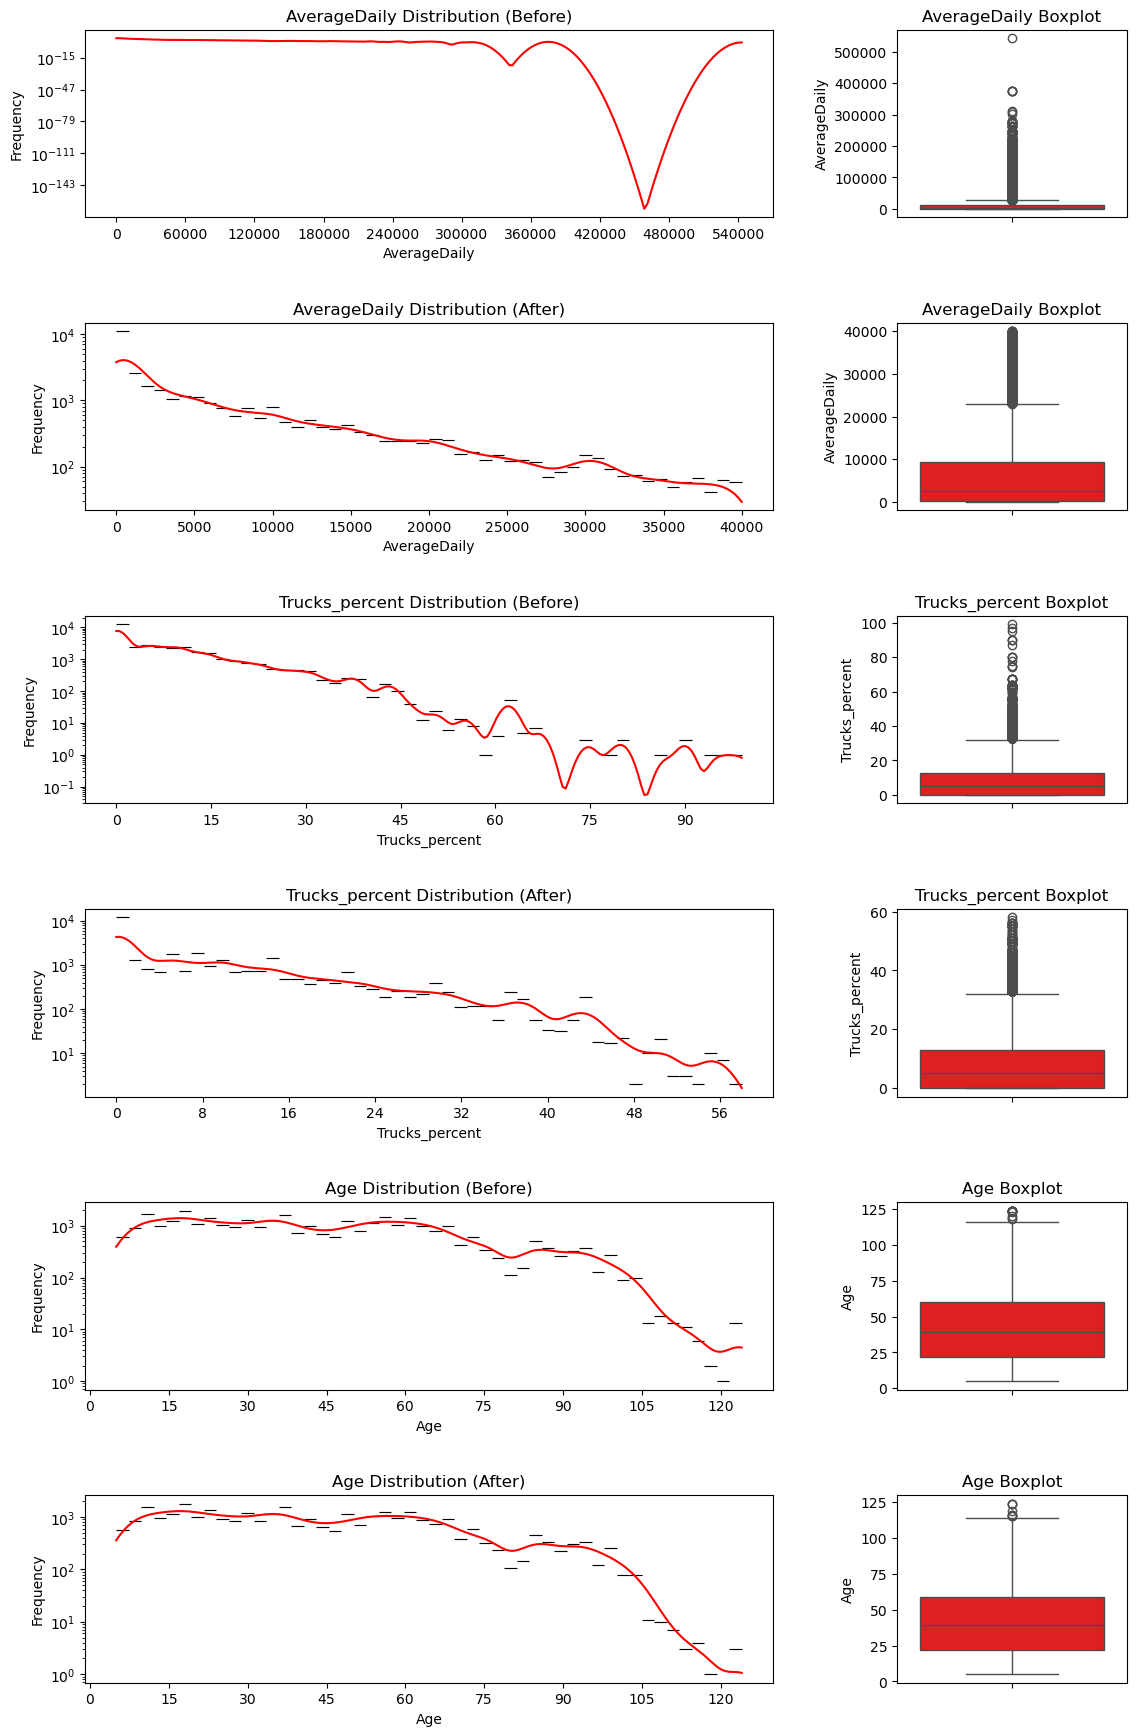

In [675]:
num_rows = 6
fig = plt.figure(figsize=(12, num_rows * 3))
gs = gridspec.GridSpec(num_rows, num_columns, width_ratios=[3, 1]) # Adjust width_ratios to change size
axes = [fig.add_subplot(gs[i // num_columns, i % num_columns]) for i in range(num_rows * num_columns)]
plot_tracker = 0

# loop for the numerical scatter plots
for col in numerical_columns:
    if col == 'Age' or col == 'Trucks_percent' or col == 'AverageDaily':
        # column 1 
        sns.histplot(df_subset[col], kde=True,log_scale=(False,True), ax=axes[plot_tracker], color='red', bins=50)
        axes[plot_tracker].set_title(f'{col} Distribution (Before)')
        # axes[plot_tracker].set_xlabel(col)
        axes[plot_tracker].set_ylabel('Frequency')
        axes[plot_tracker].xaxis.set_major_locator(MaxNLocator(prune='both', nbins=10))
        plot_tracker += 1
        
        # columns 2 
        sns.boxplot( y=df_subset[col], ax=axes[plot_tracker], color='red')
        axes[plot_tracker].set_title(f'{col} Boxplot')
        axes[plot_tracker].set_xlabel(' ')
        # axes[plot_tracker].set_ylabel(col)
        if plot_tracker == 1 or plot_tracker == 5 : plot_tracker += 3 
        else: plot_tracker -= 7

# make the changes
historic_index = df.loc[df[ 'Historic'] == 'Register'].index
df_subset = df_subset.loc[~df_subset.index.isin(historic_index)]
df_subset = df_subset.loc[df_subset['Trucks_percent'] < 60]
df_subset = df_subset.loc[df_subset['AverageDaily'] < 40000]

for col in numerical_columns:
    if col == 'Age' or col == 'Trucks_percent' or col == 'AverageDaily':
        # column 1 
        sns.histplot(df_subset[col], kde=True, log_scale=(False,True), ax=axes[plot_tracker], color='red', bins=50)
        axes[plot_tracker].set_title(f'{col} Distribution (After)')
        # axes[plot_tracker].set_xlabel(col)
        axes[plot_tracker].set_ylabel('Frequency')
        axes[plot_tracker].xaxis.set_major_locator(MaxNLocator(prune='both', nbins=10))
        plot_tracker += 1
        
        # columns 2 
        sns.boxplot( y=df_subset[col], ax=axes[plot_tracker], color='red')
        axes[plot_tracker].set_title(f'{col} Boxplot')
        axes[plot_tracker].set_xlabel(' ')
        # axes[plot_tracker].set_ylabel(col)
        plot_tracker += 3
plt.tight_layout(pad=3.0)
plt.show()


### Part 3.2 | Target vs Predictor Relationships 
In this section, we will examine the relationships between the five predictor variables ***Age, Average Daily Traffic, Trucks Percent, Material, Design*** against the **Condition**. The objective of this analysis is to: 

*  To understand how each predictor influences the target variable
* Identify key drivers and understand causality. 

#### Part 3.2a | Plotting

The various combinations of predictor vs target are plotted below. 
* For catergorical variables, the countplots and boxplots are used.
* For numerical variables, the scatterplots and KDE plots are used.

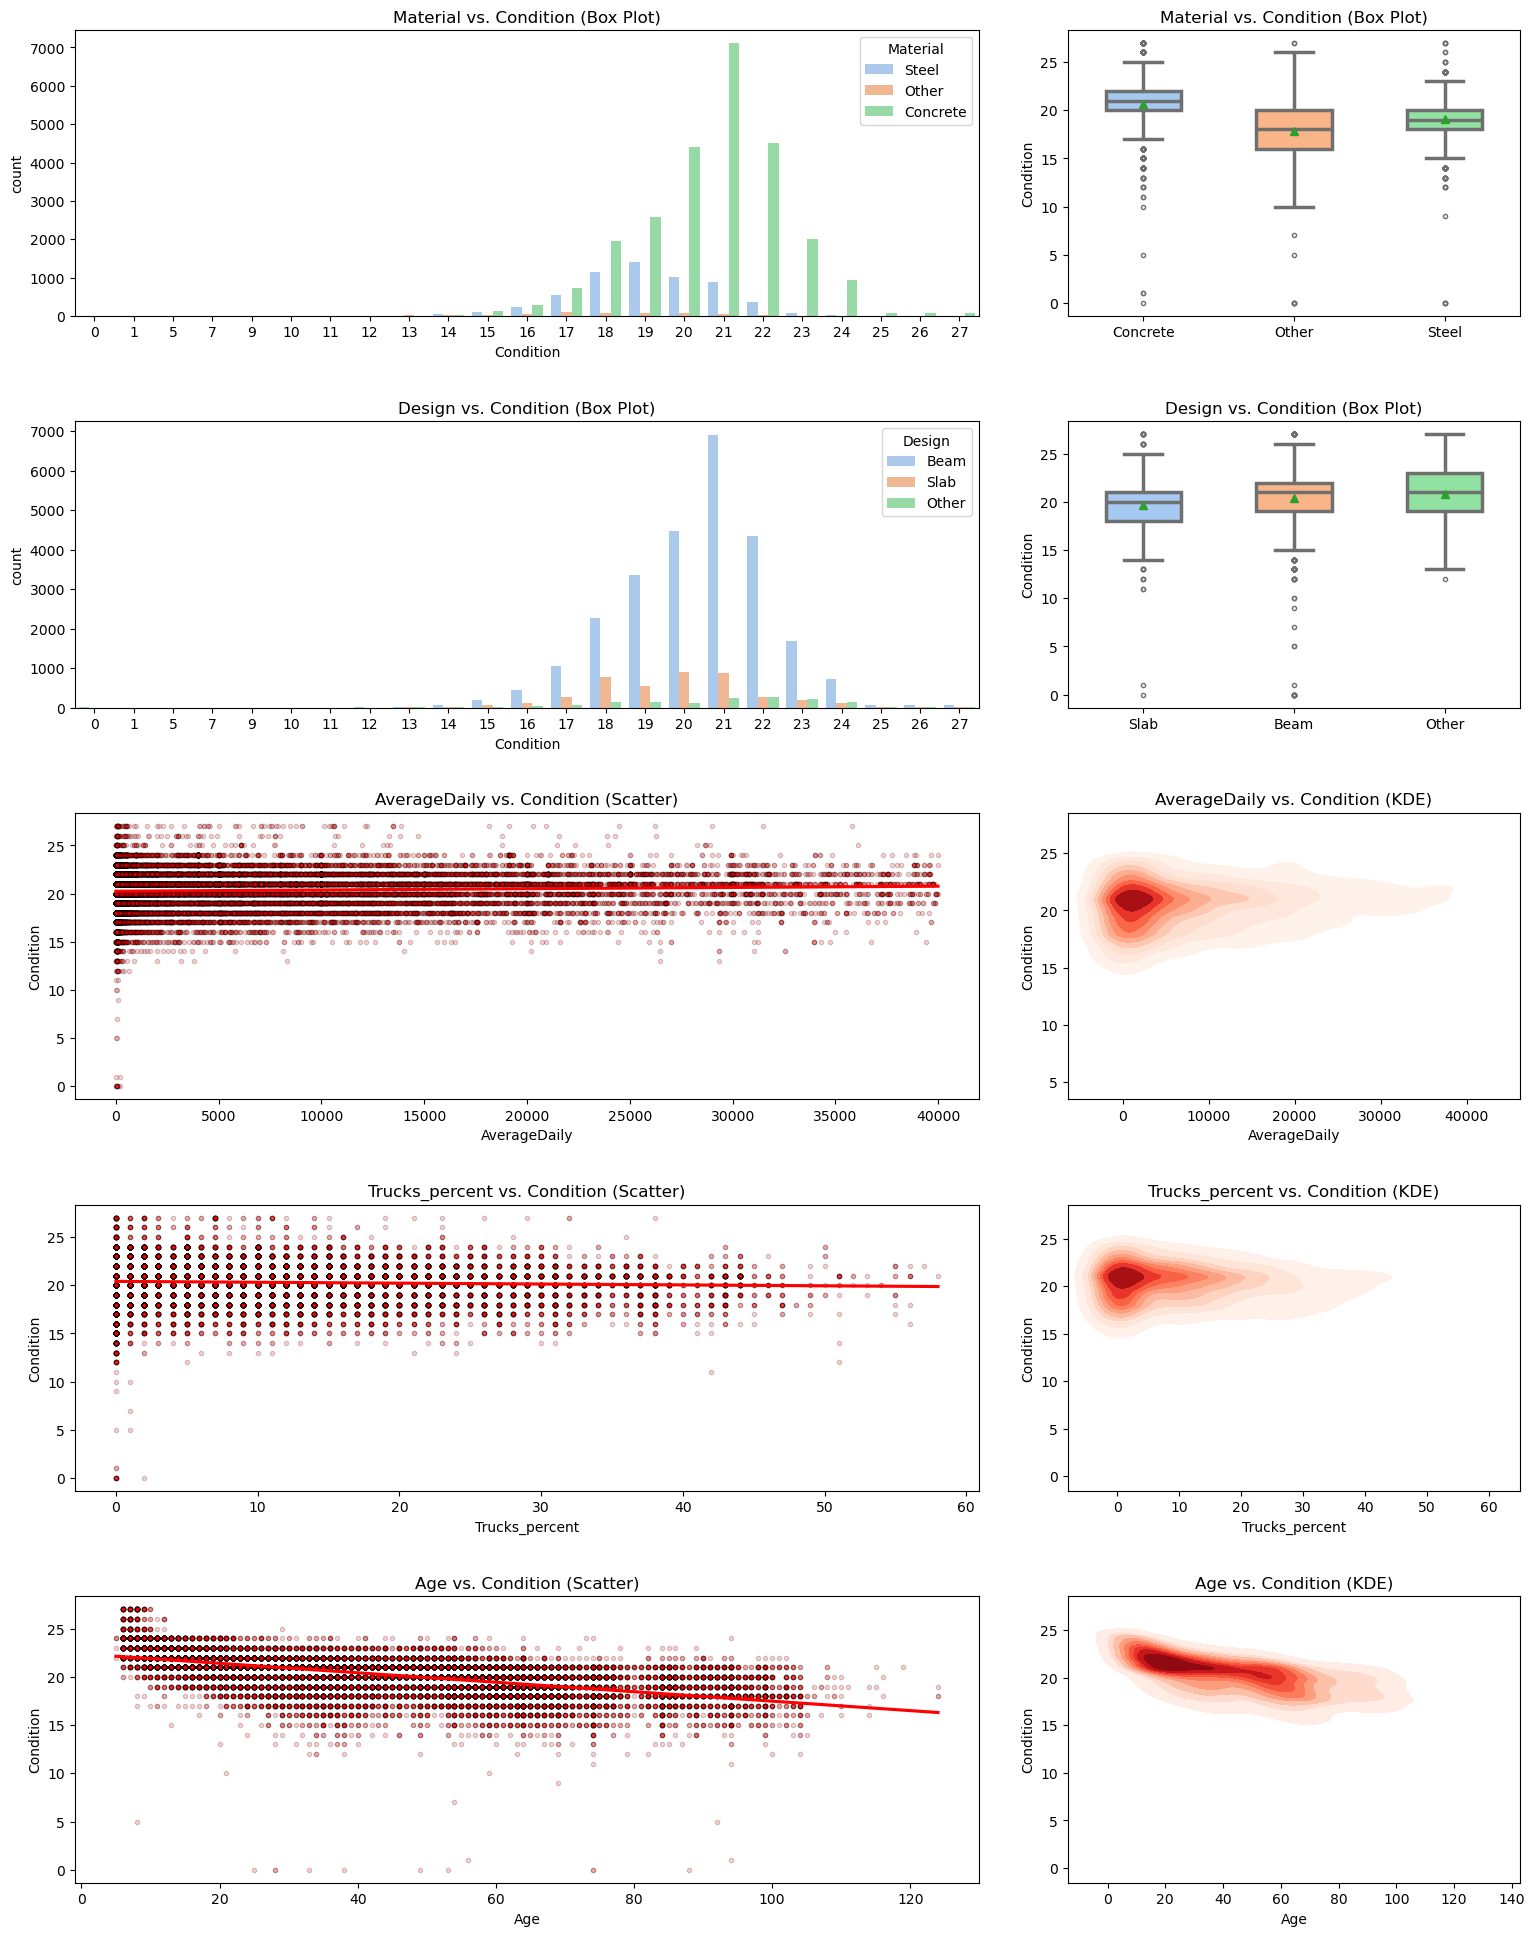

In [676]:
# now we can reassign variables lists
categorical_columns = list(df_subset.select_dtypes(include=['object']).columns)
numerical_columns = list(numerical_columns)
numerical_columns.remove('Condition')
all_columns.remove('Condition')
dependant_variables = 'Condition'

# declare the subplots
num_columns = 2
num_rows = 5
fig = plt.figure(figsize=(16, num_rows * 4))
gs = gridspec.GridSpec(num_rows, num_columns, width_ratios=[2, 1]) # Adjust width_ratios to change size
axes = [fig.add_subplot(gs[i // num_columns, i % num_columns]) for i in range(num_rows * num_columns)]

# loop for the catergorical box plots
plot_tracker = 0
for col in categorical_columns:
    
    # column 1  
    sns.countplot(df_subset, x=df_subset['Condition'], hue=df_subset[col], ax=axes[plot_tracker], palette="pastel")
    # sns.kdeplot(df_subset.sample(frac=0.1), x= df_subset['Condition'], hue=df_subset[col], ax=axes[plot_tracker], palette="pastel")
    axes[plot_tracker].set_title(f'{col} vs. {dependant_variables} (Box Plot)')
    plot_tracker += 1
    
    # column 2 
    sns.boxplot(x=df_subset[col], y=df_subset['Condition'], ax=axes[plot_tracker], color='red', palette='pastel', hue=df_subset[col], width=0.5, linewidth=2.5, fliersize=3, saturation=0.9, showmeans=True, notch=False)
    axes[plot_tracker].set_title(f'{col} vs. {dependant_variables} (Box Plot)')
    axes[plot_tracker].set_xlabel(' ')
    axes[plot_tracker].set_ylabel(dependant_variables)
    plot_tracker += 1

# loop for the numerical scatter plots
for col in numerical_columns:
    
    #  column 1
    sns.scatterplot(x=df_subset[col], y=df_subset['Condition'], ax=axes[plot_tracker], color='red', alpha=0.2, s=10,   markers=True, edgecolor='black', linewidth=0.8)
    sns.regplot(x=df_subset[col], y=df_subset['Condition'], scatter=False, color='red', ax=axes[plot_tracker])
    axes[plot_tracker].set_title(f'{col} vs. {dependant_variables} (Scatter)')
    # axes[plot_tracker].set_xlabel(' ')
    axes[plot_tracker].set_ylabel(dependant_variables)
    plot_tracker += 1
    
    # column 2
    sns.kdeplot(data=df_subset.sample(frac=0.1), x=col, y='Condition', cmap='Reds', fill=True, ax=axes[plot_tracker],)
    axes[plot_tracker].set_title(f'{col} vs. {dependant_variables} (KDE)')
    # axes[plot_tracker].set_xlabel(' ')
    axes[plot_tracker].set_ylabel(dependant_variables)
    plot_tracker += 1

plt.tight_layout(pad=3.0)
# fig.delaxes(axes[7])

### Part 3.2b | Observations

* ***Material vs Condition***
    1. **Concrete** has the highest mode, mean and median of any material. 
    2. **Steel** has the 2nd highest. 
    2. **These results indicate the material is a predictor of bridge condition**
    3. **Other** has the largest IQR. This is to be expected however, due to the combination of the other catergories 
    4. The most common bridges are Concrete, followed by Steel followed by other 
* ***Design vs Condition***
    1. There is little difference between the 3 catergories. 
    2. There is a slightly lower median for the ***Slab*** design. Indicating a small association.
    2. ***This indicates that there is not significant link between design and condition***

* **AverageDaily / Truck_percent vs Condition** Both are exteremly similar, and represent a measure of the quantity of vehicles using the bridge, so are grouped 
    * The denisity of both variables demonstrate that bridges have traffic volumnes that are relatively low compared to the possible range. Indicating that some bridges with extremely high traffic volumes will affect the model. ***The extreme outliers have been removed to mitigate this*** 
    * There appearts to be **no correlation between the variables and the condition**. Both Regresion lines exhibit a negligable slope
    * ***This suggests there is no correlation between the variables and the condition***

* ***Age vs Condition***
    * The highest density is in the 15 - 35 year range
    * There is a slight negative negative correlation between age and condition. Indicating that the bridges do deteriorate over time.
    * **Age is a predictor of bridge condition**


### Part 3.3 | Predictor vs Predictor Relationships
In this section, we will examine the relationships between the five predictor variables ***Age, Average Daily Traffic, Trucks Percent, Material, Design*** . The findings of this analysis will allow us to: 
* Identify correlations, multicollinearity, and interactions between predictors.

#### Part 3.3a | Numerical vs Numerical

This analysis shows that there is very little correlation between the variables. Indicating that they are independent of each other. This will have the benefit of reducing multicollinearity.

***Some Observations Are:***

* 'Trucks_percent' and ***AverageDailyTraffic*** exhibit a triangular scatter. Meaning that the higher average daily traffic, the less likely the percentage of traffic will be trucks (and vice versa) 
* There are some outliers in the for ***AverageDaily*** and ***trucks_percent*** that have extremely high amounts of traffic or proportions of trucks. 
* The highest correlation is 0.24 bewteen **Age & trucks_percent**. This is well below the 0.7 threshold for significance.

The scatter matirx and the corelation matirx are shown below.



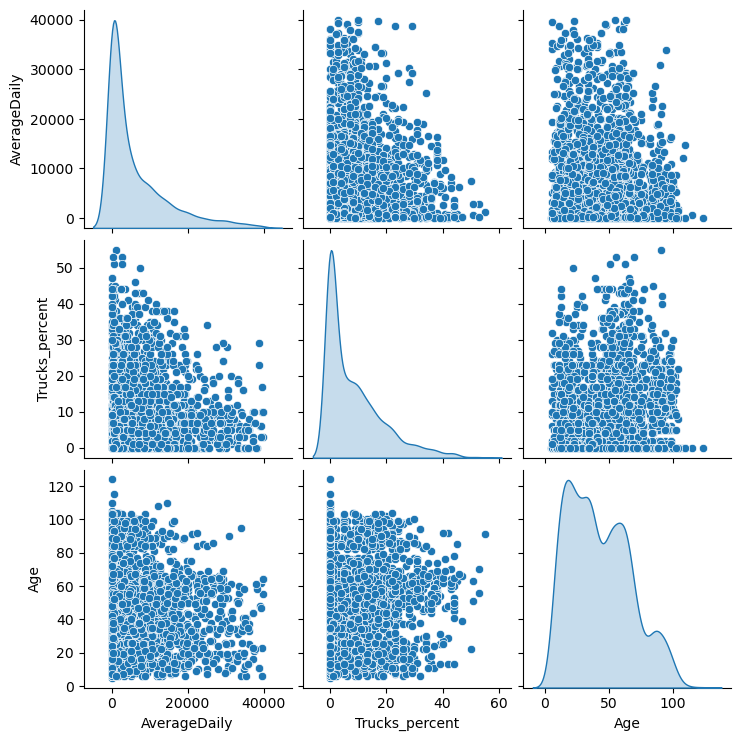

<Axes: >

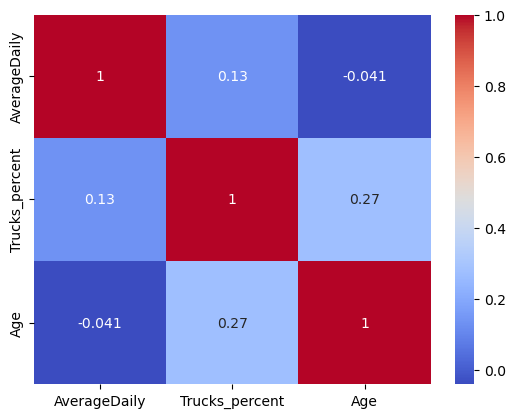

In [677]:
# plot the scatter matrix and the corelation matirx in a heatmap 
pair_grid = sns.pairplot(df_subset[numerical_columns].sample(frac=0.1), diag_kind='kde' )
plt.show()
corr_matrix = df_subset[numerical_columns].sample(frac=0.1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Part 3.3b | Catergorical vs Catergorical

This analysis shows the frequency distributions of  the 2 catergorical variables. 

***Some Observations Are:***

* ***Concrete*** with ***Beam*** design is by far the most common combination. Making up 64% of the dataset.
* There are no ***Slab*** designs that are not made of ***concrete***

The contingency table and the heatmap are shown below.


Design,Beam,Other,Slab
Material,,,
Concrete,0.629915,0.032084,0.133216
Other,0.014798,0.001786,0.000000
Steel,0.177037,0.011162,0.000000


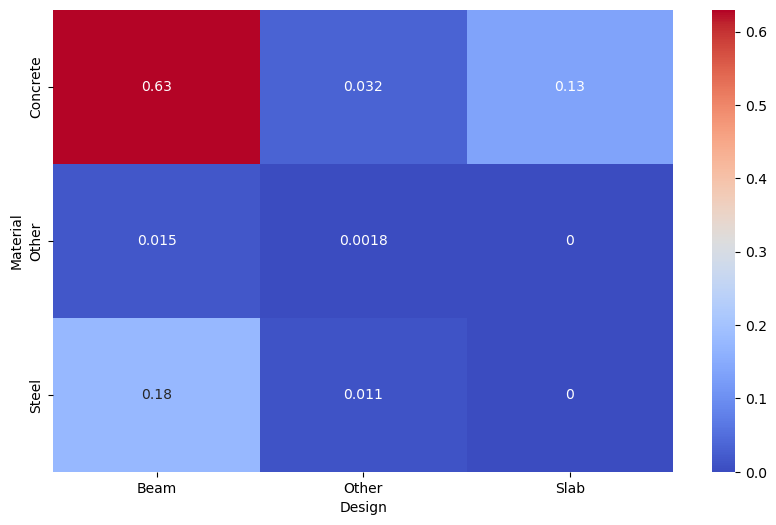

In [678]:
# create the contingency table
contingency_table = pd.crosstab(df_subset['Material'], df_subset['Design'], normalize='all')
display(contingency_table)

# plot this data in a heatmap
plt.figure(figsize=(10, 6)) 
sns.heatmap(contingency_table, annot=True, cmap='coolwarm')
plt.xlabel('Design')
plt.ylabel('Material')
plt.show()

#### Part 3.3c | Catergorical vs Numerical

The ***AverageDaily, Trucks_percent, Age*** variables are shown plotted against the ***Material, Design*** variables as kdeplots and boxplots below

****Some Observations Are:****

* ***Concrete*** is the most frequent material by far, followed by ***Steel*** and then ***Other***. This will skew the model towards concretes characteristics.   
* ***Beam*** is the msot common design by far, followed by ***slab*** and then ***other***. This will skew the model towards beam design characteristics.
* ***AverageDaily*** vs ***Material***
    * ***Concrete*** and ***Steel*** bridges both have a high range of averageDaily compared to other materials, They are positively skewed. 
    * ***Other*** Material types are the least frequent and have a fewer outliers. The data is much less skewed.  
    * ***The difference in variability suggests that some underlying dependancies***. 
* ***AverageDaily*** vs ***Design***
    * ***Beam*** designs show the most positive skew, while slab and other show a similar range of outliers.  
    * While ***beam*** is already the most likely design, as the ***AverageDaily*** increases this frequency increases. Above 20000 it becomes exclusively ***Beam*** designs 
    * * ***The difference in variability suggests that some underlying dependancies***. 
* ***Trucks_percent*** vs ***Material***
    * ***Concrete*** bridges show the greatest positive skew, followed by ***steel*** and then ***other***. The hgiher proportion of trucks per day, the more likely a bridge is to not be ***Other*** and more likely ***Steel*** and most likely ***Concrete***.
    * * ***The difference in variability suggests that some underlying dependancies***. 
* ***Trucks_percent*** vs ***Design***
    * Not much new information is gleaned from this plot. 
* ***Age*** vs ***Material*** 
   * The median age across all materials is roughly the same. Indicating that ***Age*** and ***material*** have a weak dependance. 
   * The ***Other*** catergory exhibits the smallest IQR, showing more concentrated ages around 40 years. 
   * ***However the difference in variability may suggest some weak underlying dependancies***. 
* ***Age*** vs ***Design***
    * While all 3 designs types have similar ranges, ***slab*** design has the oldest median, followed by ***beam*** and then ***other***. This suggests an association bewteen ***Design*** and ***Age***.

The different combinations are shown as kdeplots and boxplots below

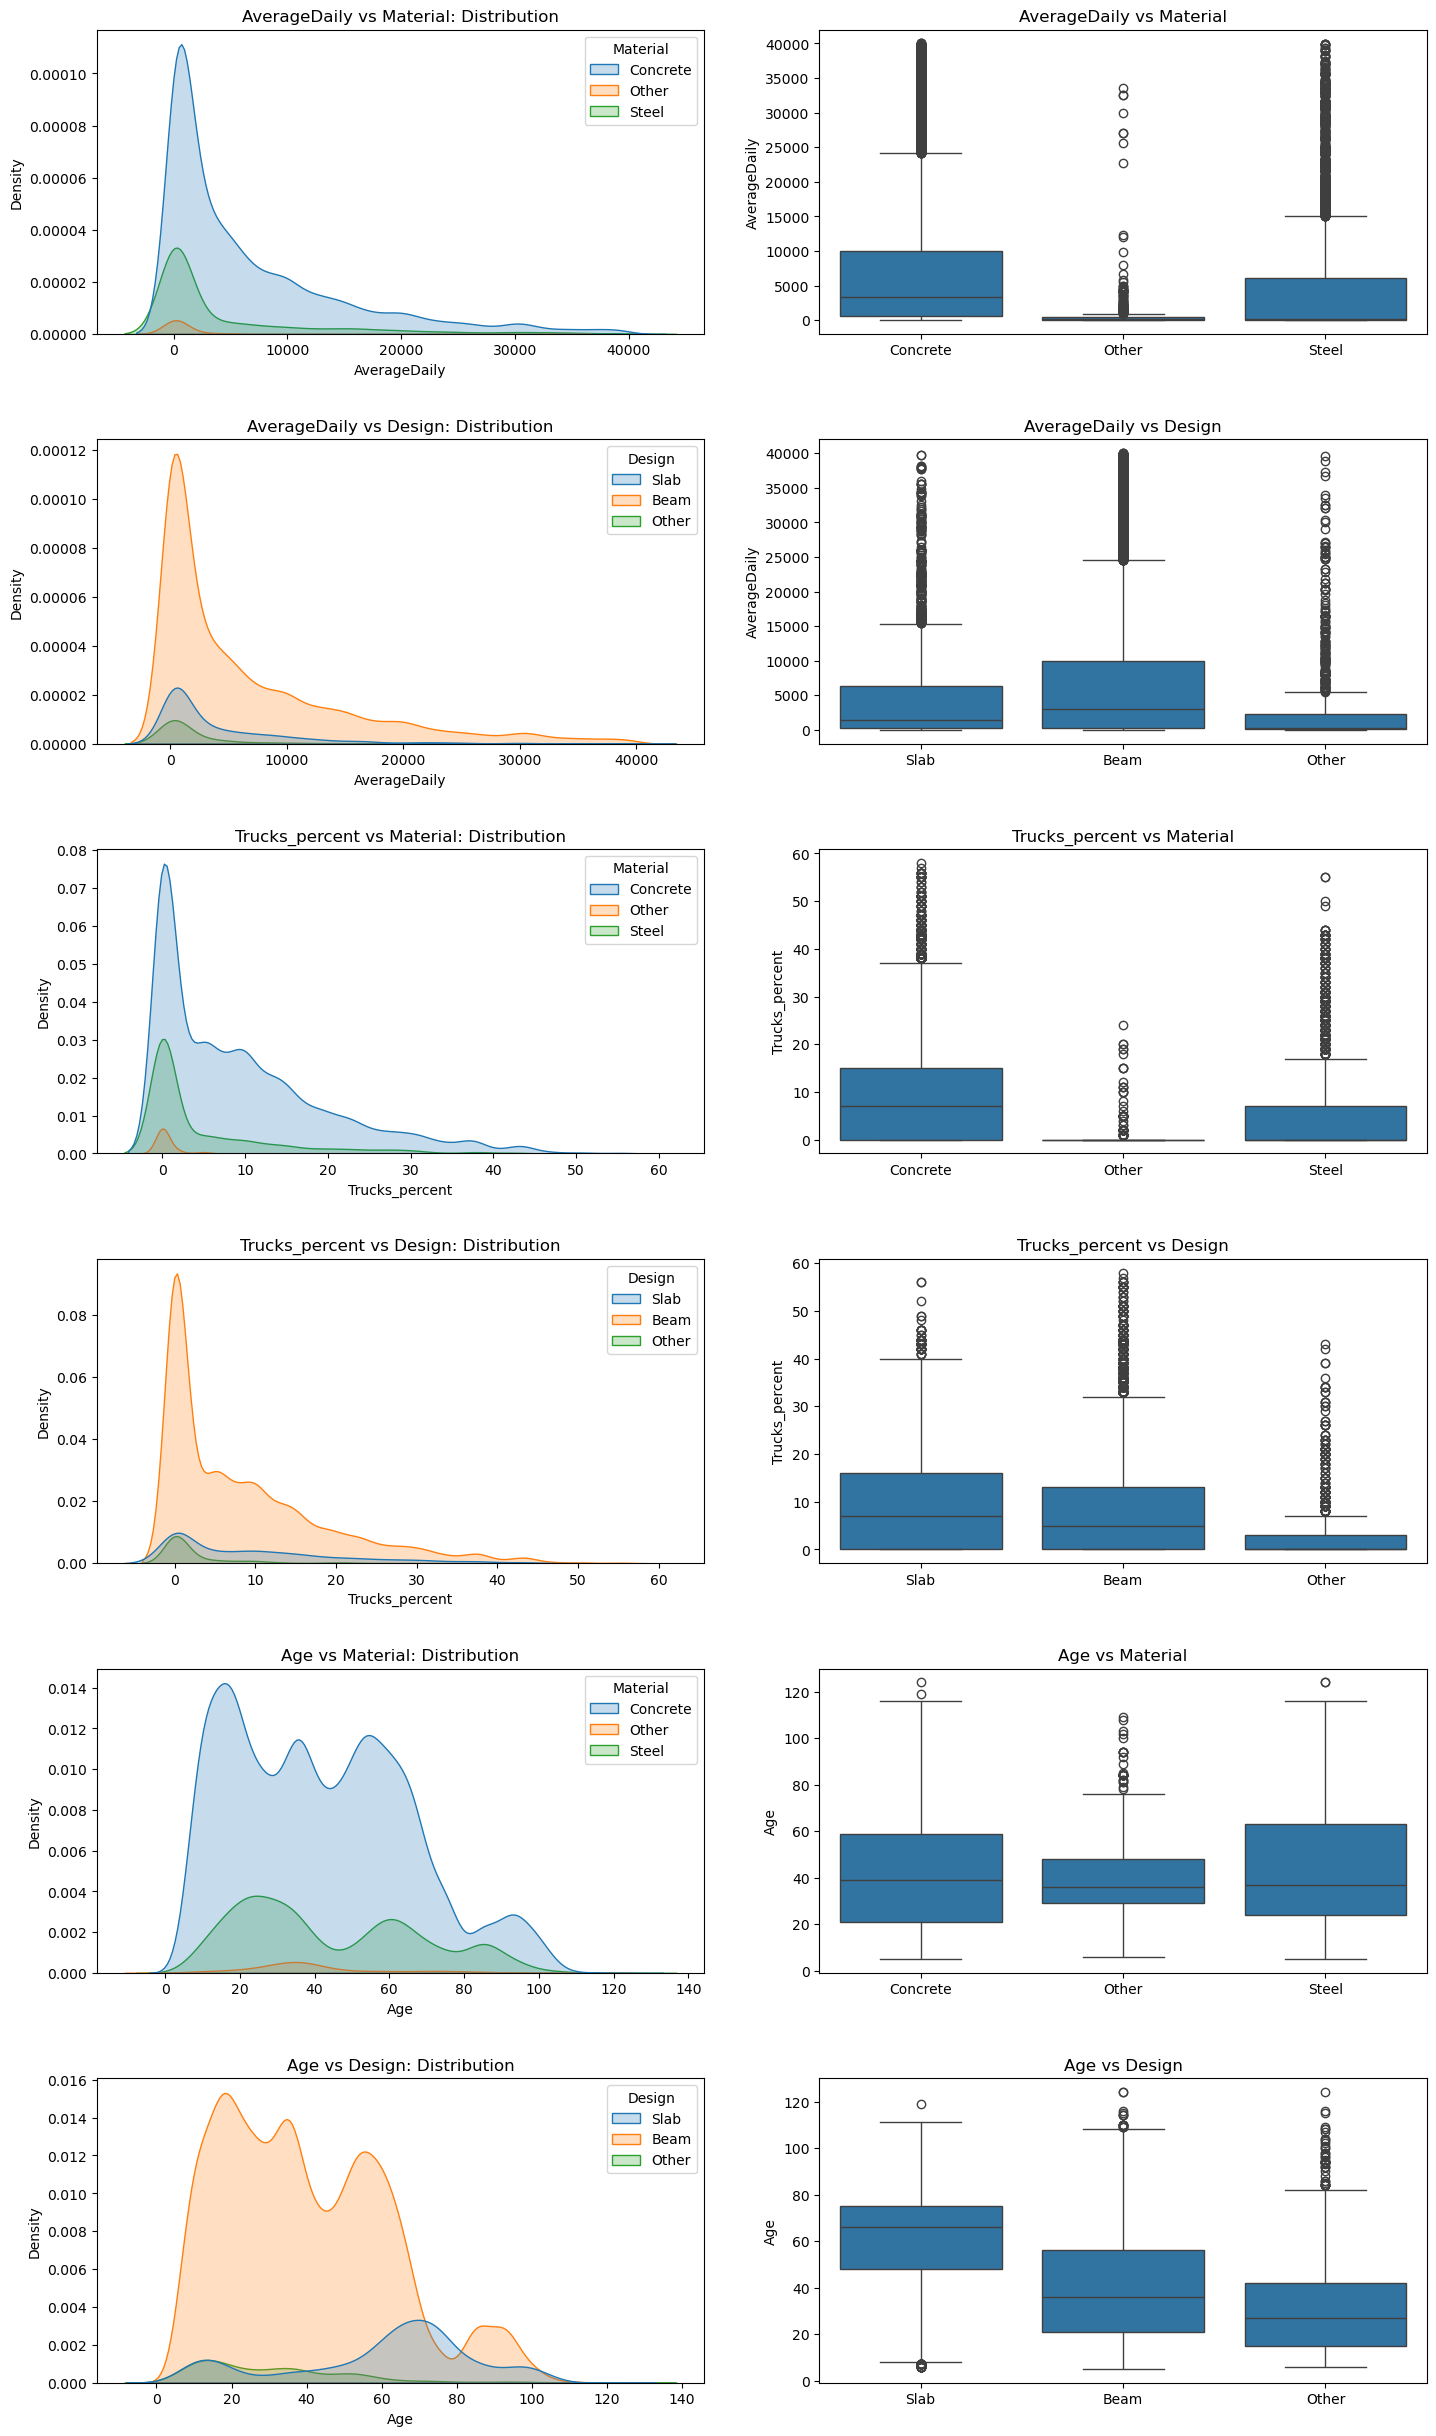

In [679]:
num_columns = 2
num_rows = 6
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 25))
plot_tracker = 0
axes = axes.flatten()

# Create boxplots for numerical vs categorical
for num_col in numerical_columns:
    for cat_col in categorical_columns:
        #column 1       
        sns.kdeplot(data=df_subset, x=num_col, hue=cat_col, fill=True, ax=axes[plot_tracker])
        axes[plot_tracker].set_title(f'{num_col} vs {cat_col}: Distribution')
        axes[plot_tracker].set_xlabel(num_col)
        # axes[plot_tracker].set_ylabel(cat_col)
        plot_tracker += 1

        # column 2
        sns.boxplot(x=df_subset[cat_col], y=df_subset[num_col], ax=axes[plot_tracker])
        # sns.barplot(data=df_subset, x=cat_col, y=num_col,  ax=axes[plot_tracker], color='red', alpha=0.3)
        axes[plot_tracker].set_title(f'{num_col} vs {cat_col}')
        axes[plot_tracker].set_xlabel('')
        axes[plot_tracker].set_ylabel(num_col)
        plot_tracker += 1
plt.tight_layout(pad=3.0)
plt.show()

## Part 3.4 | Preliminary Conclusions

Having completed the exploratory data analysis, we can now make some preliminary conclusions about the data.
 
***Conclusions:***
> * 3 of the 5 variables, show some form of influence on the Target variable. However only ***Age*** shows a strong association. While ***Material & Design*** suggest some influence, there IQRs' are signnificantly overlapped. Making their interpretation harder.
> * 2 of the five, ***AverageDialy * Trucks_percentage***  show no associations at all. Demonstrating almost perfectly flat regression  lines on thir scatter plots aggainst condition. 
> * As the ***slab*** design shows a slight association with worse condition. It also has an association with ***Age***, which is a predictor of ***Condition*** it therefore could be a significant predictor. However as it is a comparatively low frequency design the affect may be insignificant. 
>
> To Summarize - I beleive the ***Age*** will have the most influence on a bridges current condition. ***Mterial & Design*** will have a lesser, but potentially significant, influence. While ***AverageDaily & Truck_percentage*** will have the least incluence, if any.
## Part 4 | Regression Analysis
This section constructs a linear regression model to examine the effects of the five predictor variables on the target variable, bridge condition. The coefficient of determination (R2) and the Root Mean Squared Error (RMSE) will be presented and evaluated. The distribution of residuals will also be shown and discussed. Finally, the regression coefficients will be used to compare the impact of each predictor variable, enabling us to draw conclusions about their relative influence on bridge condition.

### Part 4.1 | Fitting The Model

A linear regression model is fitted. 
* The catergorical variables are one-hot-encoded to create dummy variables.

In [680]:
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression   
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import statsmodels.api as sm


# First use on-hot-encoding to create dummy variables for material and design 
df_subset = pd.get_dummies(df_subset, columns=['Material', 'Design'], drop_first=True) 

### Part 4.2 | Evaluating The Coefficients 

The coefficients are are multiplied by their corresponding variables range to find their scaled impact. 

In [681]:
# assign the independant and dependant variables
X = df_subset[df_subset.columns.drop('Condition')]
y = df_subset['Condition']

model = LinearRegression().fit(X, y)

# convert the one-hot-encoded catergoial variables into binary
X = X.map(lambda x: int(x) if isinstance(x, bool) else x)

print('The variables and their coefficients are shown here: ')
print('Model Intercept', model.intercept_)

for i, col in enumerate(X.columns):
    if col == 'Material_Other' or col == 'Material_Steel' or col == 'Design_Other' or col == 'Design_Slab':
        print((f'The scaled impact of {col} is its coefficient({model.coef_[i]:.3f}) x the range (1- 0) = {model.coef_[i] * (1 - 0)}'))
    else:
        print(f'The scaled impact of {col} is its coefficient({model.coef_[i]:.3f}) x the range ({X[col].min()} - {X[col].max():.3f}) = {model.coef_[i] * (X[col].max() - X[col].min())}')

The variables and their coefficients are shown here: 
Model Intercept 22.652366312255193
The scaled impact of AverageDaily is its coefficient(-0.000) x the range (0 - 39990.000) = -0.0883287864042532
The scaled impact of Trucks_percent is its coefficient(0.007) x the range (0.0 - 58.000) = 0.3856930652610364
The scaled impact of Age is its coefficient(-0.049) x the range (5 - 124.000) = -5.781145915232514
The scaled impact of Material_Other is its coefficient(-2.852) x the range (1- 0) = -2.852101986951521
The scaled impact of Material_Steel is its coefficient(-1.438) x the range (1- 0) = -1.4383975083358107
The scaled impact of Design_Other is its coefficient(0.139) x the range (1- 0) = 0.13917005436598093
The scaled impact of Design_Slab is its coefficient(-0.072) x the range (1- 0) = -0.07236764396001895


| Variable         | Coefficient | Impact | 
|------------------|-------------| ---| 
| Intercept        | 22.654      | The starting value of out predictions, when all other factors are at zero value | 
| AverageDaily     | -0.088      |  For each extra average daily vehicle, the predicted condition is reduced by 0.088 | 
| Trucks_percent   | 0.386       | For each percentage increase in Truck proportion, the predicted condition is increased by 0.386 | 
| Age              | -5.781      | For each additional year in Age, the predicted condition is reduced by 5.781 | 
| Material_Other   | -2.852      | When the bridge material is "Other", the predicted condition is reduced by 2.852 compared to the baseline material |
| Material_Steel   | -1.438      | When the bridge material is "Steel", the predicted condition is reduced by 1.438 compared to the baseline material |
| Design_Other     | 0.139       | When the bridge design is "Other", the predicted condition is increased by 0.139 compared to the baseline design |
| Design_Slab      | -0.072      | When the bridge design is "Slab", the predicted condition is reduced by 0.072 compared to the baseline design |

***Comparing this with the preliiminary predictions:***
* The age was correctly predicted as the most important predictor
* Truck percentage and average daily vehicles was correctly predicted as the least important predictors
* Concrete was predicted as the mateiral most likely to be in better condition 
    * Followed be Steel
    * Followed by Other
* The slab design was predicted as the design most likely to be in worse condition

### Part 4.3 | R2 and RMSE

* ***R²  = 0.452***: The model explains about 45.2% of the variability in the condition variable. This leaves plenty of room for unexplained factors or potential improvements.

* ***RMSE  = 1.473***: On average, the model's condition predictions deviate from the actual condition by about 1.473. Of the potential range of 27 - this gives a percentage of **5.45%**

In [682]:
y_pred = model.predict(X)
print('R^2 - training: ', r2_score(y, y_pred))
print('Root Mean Squared Error(training):  ', root_mean_squared_error(y, y_pred))

R^2 - training:  0.45247644585275637
Root Mean Squared Error(training):   1.473250633784173


### Part 4.4 | Residual Analysis

In this section the residual produced by the analysis are plotted and analysed. 

#### Part 4.4a | Plots

Here we look at the following:
* (1) Residual histogram
* (2) Q-Q plot
* (3) Residuals vs Predicted
* (4) Actual vs Predicted

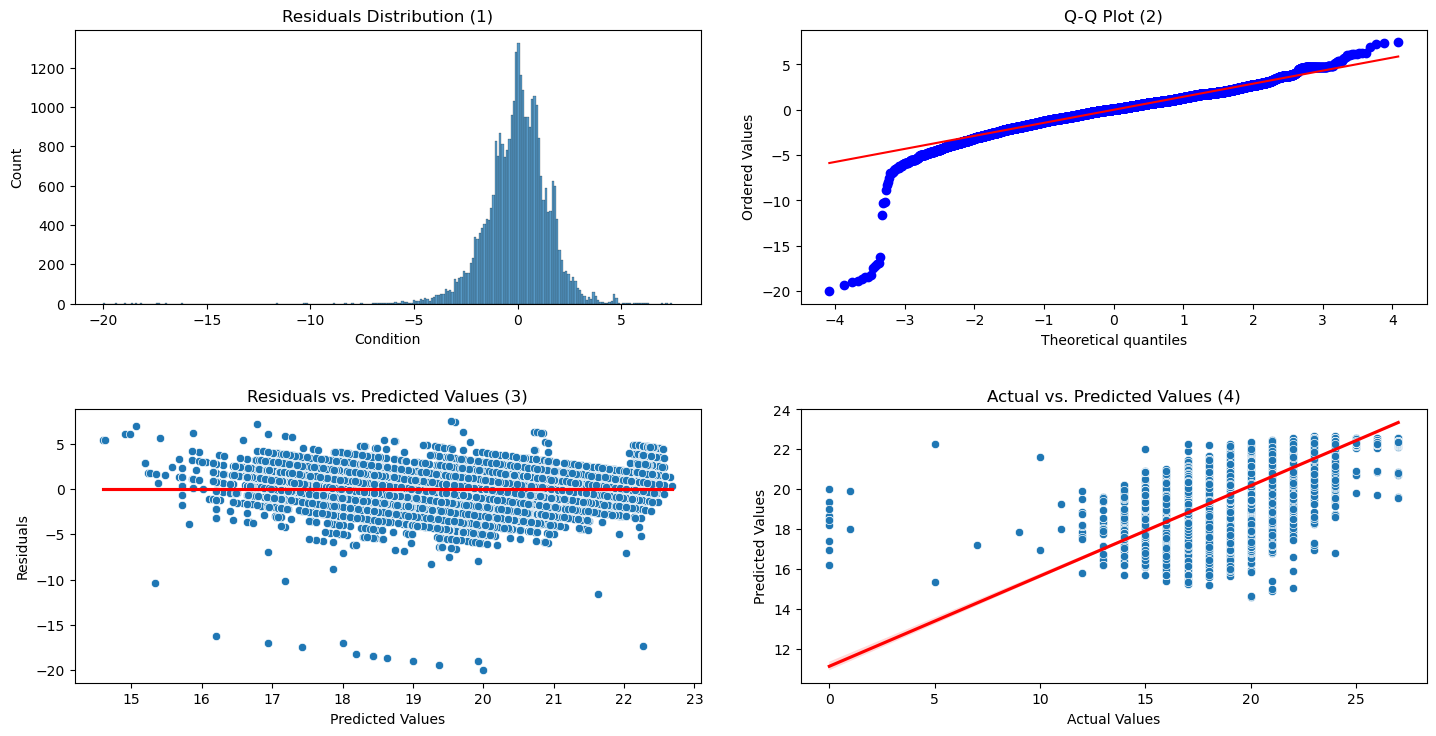

In [683]:

residuals = y - y_pred

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

# residual histogram 
sns.histplot(x=residuals, ax=axes[0])
axes[0].set_title('Residuals Distribution (1)')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (2)')

# residuals vs predicted (residual plot)
sns.scatterplot(x=y_pred, y=residuals, ax=axes[2])
sns.regplot(x=y_pred, y=residuals, scatter=False, color='red', ax=axes[2])
axes[2].set_title('Residuals vs. Predicted Values (3)')
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')

#  actual vs predicted
sns.scatterplot(x=y, y=y_pred, ax=axes[3])
sns.regplot(x=y, y=y_pred, scatter=False, color='red', ax=axes[3])
axes[3].set_title('Actual vs. Predicted Values (4)')
axes[3].set_ylabel('Predicted Values')
axes[3].set_xlabel('Actual Values')
fig.tight_layout(pad=3.0)


#### Part 4.4b | Analysis

***Some Observations Are***: 
* Plots 1 & 2 shows that the distribution of the residuals is almost normally distributed. However the Q-Q plot shows that model is underestimating the lower values of the model. 
* Plot 3, the residual vs predicted, shows a nearly horizontal regresion line about 0. This implies the models mean prediction error is zero. Indicating no systemic bias. However the spread of the values about the line indicated there is substantial unexplaoined variance 
* Plot 4, the actual vs predicted, shows a diagonal line indicating the model does reasonably well in matching predicted values to actual values. However there's noticeable dispersion around this diagonal, especially at the lower extreme, suggesting variability in predictions.

### Part 4.5 | Conclusion

#### Final Conclusion

**The linear regression model, utilising five predictor variables, achieved a modest R<sup>2</sup> of 0.452.** This suggests the model can **explain approximately 45.2% of the variance observed in bridge condition.** While this indicates a degree of predictive power, a substantial portion of variability remains unaccounted for. This highlights the potential influence of additional factors not encompassed within this model.

**Analysis of the residuals indicated a near-normal distribution**, suggesting the model's errors are generally random. However, the Q-Q plot revealed a tendency for the model to underestimate condition at the lower end of the scale. This could point to limitations in capturing the factors influencing the condition of bridges in poorer states.

**Of the variables investigated, *Age* emerged as the most influential predictor of bridge condition.** The analysis revealed a negative correlation, implying that as a bridge ages, its condition tends to deteriorate. This finding aligns with expectations regarding the impact of time and wear on infrastructure. 

**While *Material* and *Design* also exhibited some influence on bridge condition, their impact was less pronounced compared to *Age*.**  Concrete bridges, on average, tended to display better conditions than those constructed from steel or other materials.  

**The variables *AverageDaily* and *Trucks\_percent*, representing traffic volume and truck proportion respectively, displayed negligible influence on bridge condition.** This suggests that, within the studied dataset, traffic load may not be a primary driver of bridge deterioration. 

**In conclusion, the model provides a reasonable starting point for predicting bridge condition.** However, further analysis incorporating additional variables and potentially exploring non-linear relationships could enhance the model's predictive accuracy. 

#### Potential Improvements
***Incorporate Interaction Terms:*** The analysis revealed potential dependencies between predictors. Exploring interaction terms between these variables in the regression model may improve its accuracy by capturing combined effects. For example, an interaction term between AverageDaily and Material_Concrete could capture how the impact of traffic volume on bridge condition might differ for concrete bridges compared to other material types.

***Consider Non-Linear Relationships:*** The scatter plots for AverageDaily, Trucks_percent and Age against Condition don't show a strong linear trend. Exploring non-linear relationships, for example, by incorporating polynomial terms or using non-linear regression models, might improve the model's fit and predictive ability.

***Additional Predictor Variables:*** The modest R2 value suggests that other factors, not included in the current model, might contribute significantly to bridge condition. 

***Address Outliers:*** While some outliers were addressed, further investigation into the remaining outliers in Age, AverageDaily, and Trucks_percent could be beneficial. Understanding the reasons behind these outliers and determining appropriate handling methods (e.g., transformation, removal if justifiable) could improve the model's robustness.